In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/ml-projects/image-classification-pytorch"

/content/drive/MyDrive/ml-projects/image-classification-pytorch


In [3]:
# import required libaries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import os
import random

import cv2

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import Tensor
from torchvision import datasets, transforms

In [5]:
# checking GPU
!nvidia-smi

Tue Jun 11 08:33:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# EDA

In [6]:
for dirpath, dirnames, filenames in os.walk('./data'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in './data'.
There are 3 directories and 0 images in './data/test'.
There are 0 directories and 50 images in './data/test/driving_license'.
There are 0 directories and 50 images in './data/test/others'.
There are 0 directories and 50 images in './data/test/social_security'.
There are 3 directories and 0 images in './data/train'.
There are 0 directories and 200 images in './data/train/driving_license'.
There are 0 directories and 200 images in './data/train/others'.
There are 0 directories and 200 images in './data/train/social_security'.


In [7]:
ROOT_DIR = "./"

train_folder = ROOT_DIR + "data/train/"
test_folder = ROOT_DIR + "data/test/"

os.listdir(train_folder)

['driving_license', 'others', 'social_security']

In [8]:
def view_random_images(target_folder):
    """This function returns random images of three classes from a directory

    Args:
        target_folder (os,path): path to the folder
    """

    for path in os.listdir(target_folder):
        for i in range(3):
            temp_path = target_folder + "/" + path
            file = random.choice(os.listdir(temp_path))
            image_path = os.path.join(temp_path, file)
            img = mpimg.imread(image_path)
            plt.figure(figsize=(5,5))
            plt.imshow(img)
            plt.title(f"{path} - Shape : {img.shape}")
            plt.axis("off")

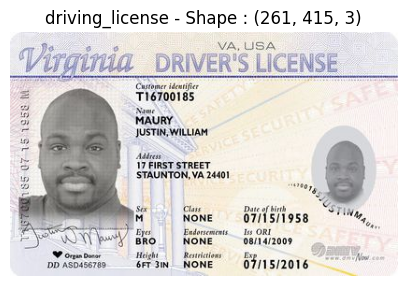

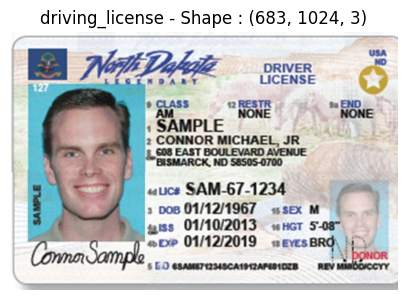

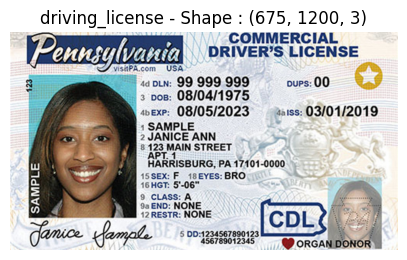

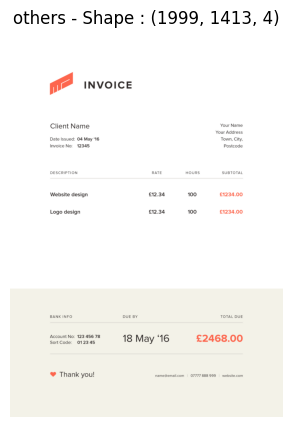

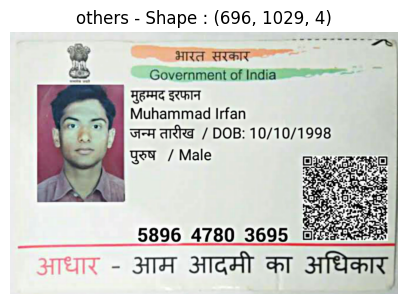

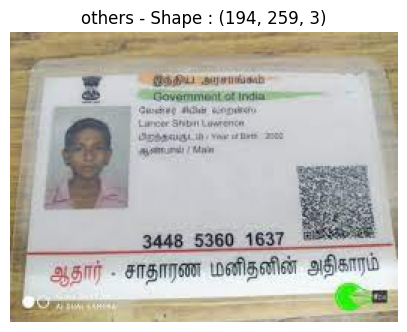

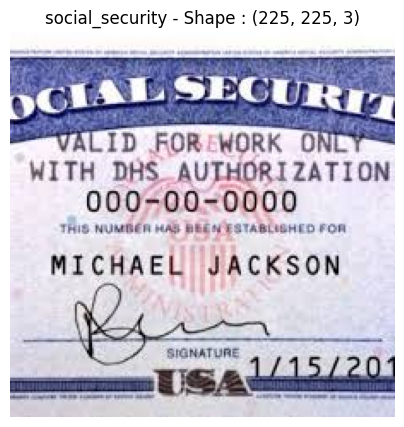

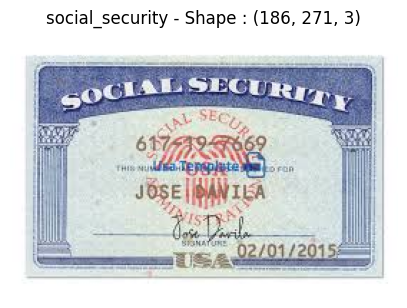

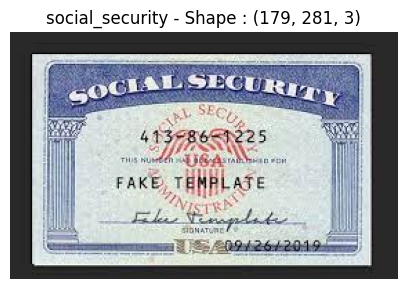

In [9]:
view_random_images("./data/train")

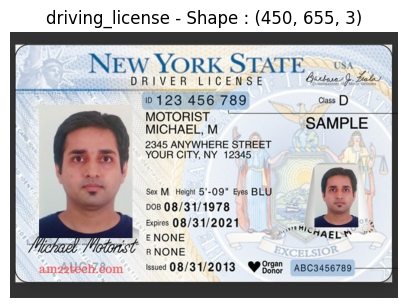

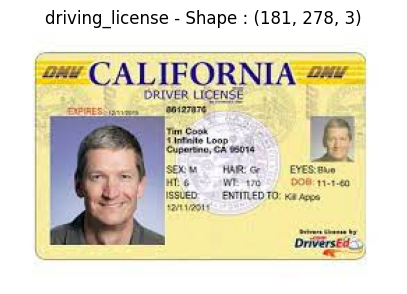

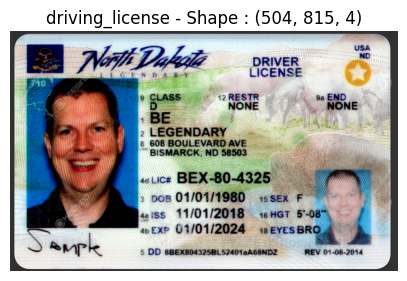

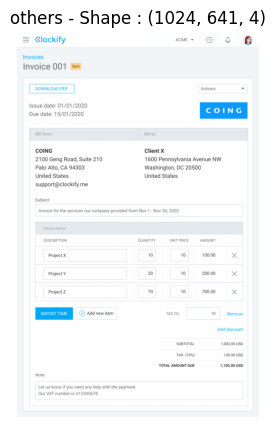

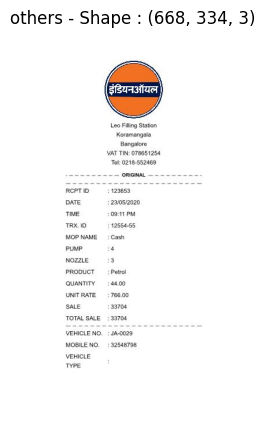

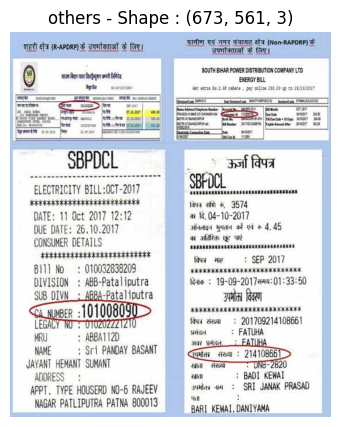

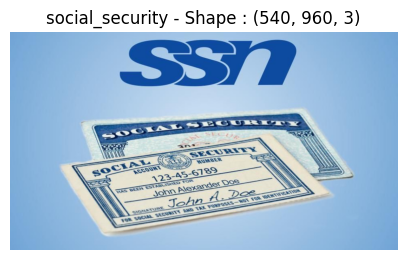

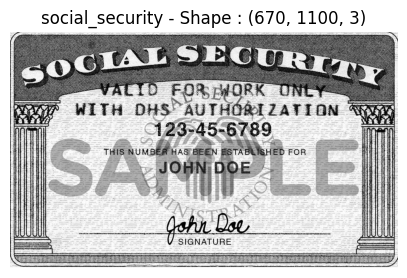

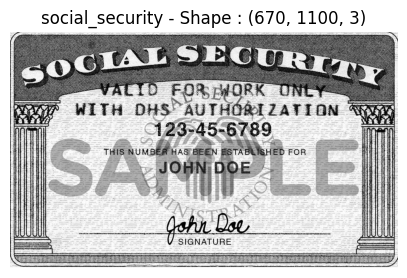

In [10]:
view_random_images("./data/test")

# DATA PREPARATION

In [11]:
class ImageDataset(Dataset):

    def __init__(self, root_dir, transform=None, IMG_SIZE=200):
        super().__init__()

        self.transform = transform
        self.img_data_array = list()
        self.class_name = list()

        classes = {'driving_license': [1, 0, 0], 'others': [0, 1, 0], 'social_security': [0, 0, 1]}

        for item in os.listdir(root_dir):
            for file in os.listdir(os.path.join(root_dir, item)):
                image_path = os.path.join(root_dir, item,  file)
                image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
                image = np.array(image).astype('float64')
                image *= 1/255.

                if len(image.shape) == 3:
                    self.img_data_array.append(image.reshape(3, 200, 200))
                    self.class_name.append(classes[item])


    def __len__(self):
        return len(self.img_data_array)


    def __getitem__(self, idx):
        image = self.img_data_array[idx]
        label = self.class_name[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


    def create_dataset(self):
        return Tensor(np.array(self.img_data_array)), Tensor(np.array(self.class_name))


transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = ImageDataset(root_dir='./data/train/', transform=transform)
test_dataset = ImageDataset(root_dir='./data/test/', transform=transform)

In [12]:
train_data, train_labels = train_dataset.create_dataset()
train_data.shape, train_labels.shape

(torch.Size([597, 3, 200, 200]), torch.Size([597, 3]))

In [13]:
test_data, test_labels = test_dataset.create_dataset()
test_data.shape, test_labels.shape

(torch.Size([149, 3, 200, 200]), torch.Size([149, 3]))

In [14]:
train_tensor = TensorDataset(train_data, train_labels)
test_tensor = TensorDataset(test_data, test_labels)

In [15]:
trainloader = DataLoader(train_tensor, batch_size=10, shuffle=True)
testloader = DataLoader(test_tensor, batch_size=10, shuffle=True)
len(trainloader), len(testloader)

(60, 15)

In [16]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([10, 3, 200, 200]), torch.Size([10, 3]))

# MODELLING

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
from torch import nn, optim

class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 3, kernel_size=50, stride=1),
            nn.MaxPool2d(kernel_size=1, stride=1, padding=0, ceil_mode=False)
        )

        self.linear = nn.Sequential(
            nn.Linear(3, 3)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x



In [32]:
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# checking if GPU is available
print(f"Is cuda available: {torch.cuda.is_available()}")


model = model.to(device)
criterion = criterion.to(device)

print(model)

Is cuda available: True
CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1))
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
  )
)


In [38]:
from tqdm.auto import tqdm
!export CUDA_LAUNCH_BLOCKING=1

In [33]:
num_epochs = 30

for epoch in tqdm(range(num_epochs)):

    model.train()
    running_loss = 0
    for images, labels in trainloader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {running_loss/len(trainloader):.4f}')


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30] - Training Loss: 1.1145
Epoch [2/30] - Training Loss: 0.5341
Epoch [3/30] - Training Loss: 0.3735
Epoch [4/30] - Training Loss: 0.3201
Epoch [5/30] - Training Loss: 0.1951
Epoch [6/30] - Training Loss: 0.1373
Epoch [7/30] - Training Loss: 0.1022
Epoch [8/30] - Training Loss: 0.0629
Epoch [9/30] - Training Loss: 0.0319
Epoch [10/30] - Training Loss: 0.0314
Epoch [11/30] - Training Loss: 0.0162
Epoch [12/30] - Training Loss: 0.0133
Epoch [13/30] - Training Loss: 0.0073
Epoch [14/30] - Training Loss: 0.0051
Epoch [15/30] - Training Loss: 0.0039
Epoch [16/30] - Training Loss: 0.0031
Epoch [17/30] - Training Loss: 0.0026
Epoch [18/30] - Training Loss: 0.0023
Epoch [19/30] - Training Loss: 0.0021
Epoch [20/30] - Training Loss: 0.0018
Epoch [21/30] - Training Loss: 0.0017
Epoch [22/30] - Training Loss: 0.0014
Epoch [23/30] - Training Loss: 0.0013
Epoch [24/30] - Training Loss: 0.0011
Epoch [25/30] - Training Loss: 0.0011
Epoch [26/30] - Training Loss: 0.0011
Epoch [27/30] - Train

In [35]:
file_path = './results/model/model.pt'
torch.save(model.state_dict(), file_path)

# VALIDATION

In [39]:
model.eval()

y_pred = []
y_true = []


with torch.inference_mode():
    for images, labels in testloader:

        images, labels = images.to(device), labels.to(device)

        output = model(images)
        _ , predicted = torch.max(output, dim=1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


true_labels = [x.argmax() for x in y_true]

In [57]:
correct, total = 0, 0

for i in range(len(y_pred)):
    if (y_pred[i] == true_labels[i]):
        correct += 1
    total += 1


print(f"Model Accuracy: {(correct/total)*100:.2f} %")

Model Accuracy: 91.95 %


In [47]:
# predicting with custom images

def pred_and_plot(image_path, model=model, IMG_SIZE=200):

    classes = {0: 'Driving_License', 1: 'Others', 2: 'Social_Security'}

    #load and prep image
    img = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    image = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    img = np.array(image).astype('float64')
    img *= 1/255.
    img = img.reshape(1, 3, 200, 200)
    img = torch.Tensor(img).to(device)

    #predicted image
    with torch.inference_mode():
        output = model(img)
        _ , predicted = torch.max(output, dim=1)
        pred_class = classes[predicted.item()]

    # plot prediction
    plt.imshow(image)
    plt.title(f"This is a '{pred_class}' document")
    plt.axis(False)




In [46]:
L1 = "./results/images/L1.jpg"
L2 = "./results/images/L2.jpg"
NIN = "./results/images/NIN.jpg"
V1 = "./results/images/V1.jpg"
V2 = "./results/images/V2.jpg"

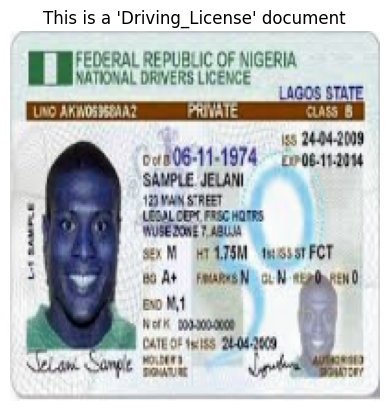

In [49]:
pred_and_plot(L1)

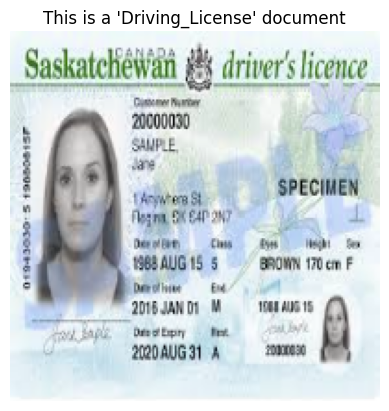

In [50]:
pred_and_plot(L2)

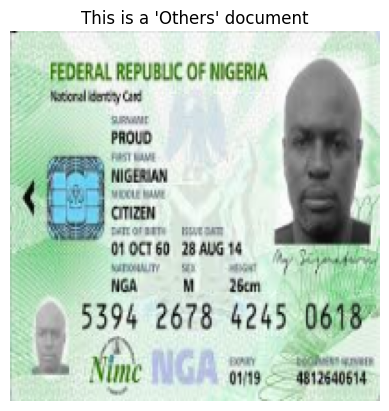

In [52]:
pred_and_plot(NIN)

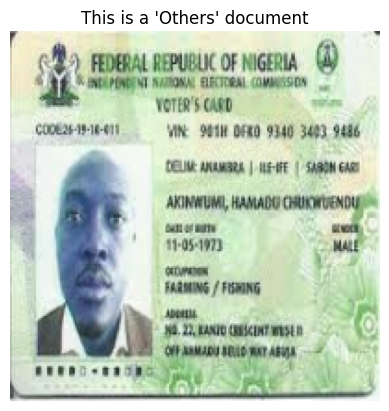

In [54]:
pred_and_plot(V1)

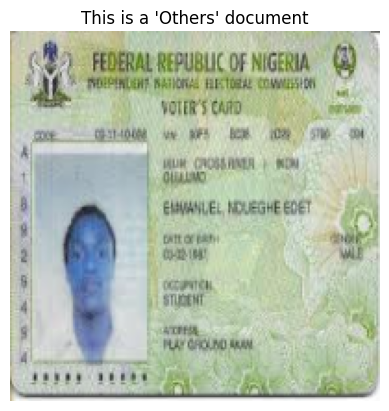

In [56]:
pred_and_plot(V2)